v2.0 - combines bollinger, rsi and ma strategies into one portfolio

/var/folders/b9/l7b2jvjs3l1b62b471c8jm7h0000gn/T/ipykernel_43962/2186378846.py:30: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, start=start_date, progress=False)


-----------------------------------------------------
 STRATEGY REPORT (Portfolio) - AAPL
-----------------------------------------------------
RSI Weight:            0.33
Bollinger Weight:      0.33
MA Crossover Weight:   0.33
-----------------------------------------------------
Sharpe Ratio:          0.795
Max Drawdown:          -19.69%
CAGR:                  11.43%
Final Equity:          1.90x
-----------------------------------------------------


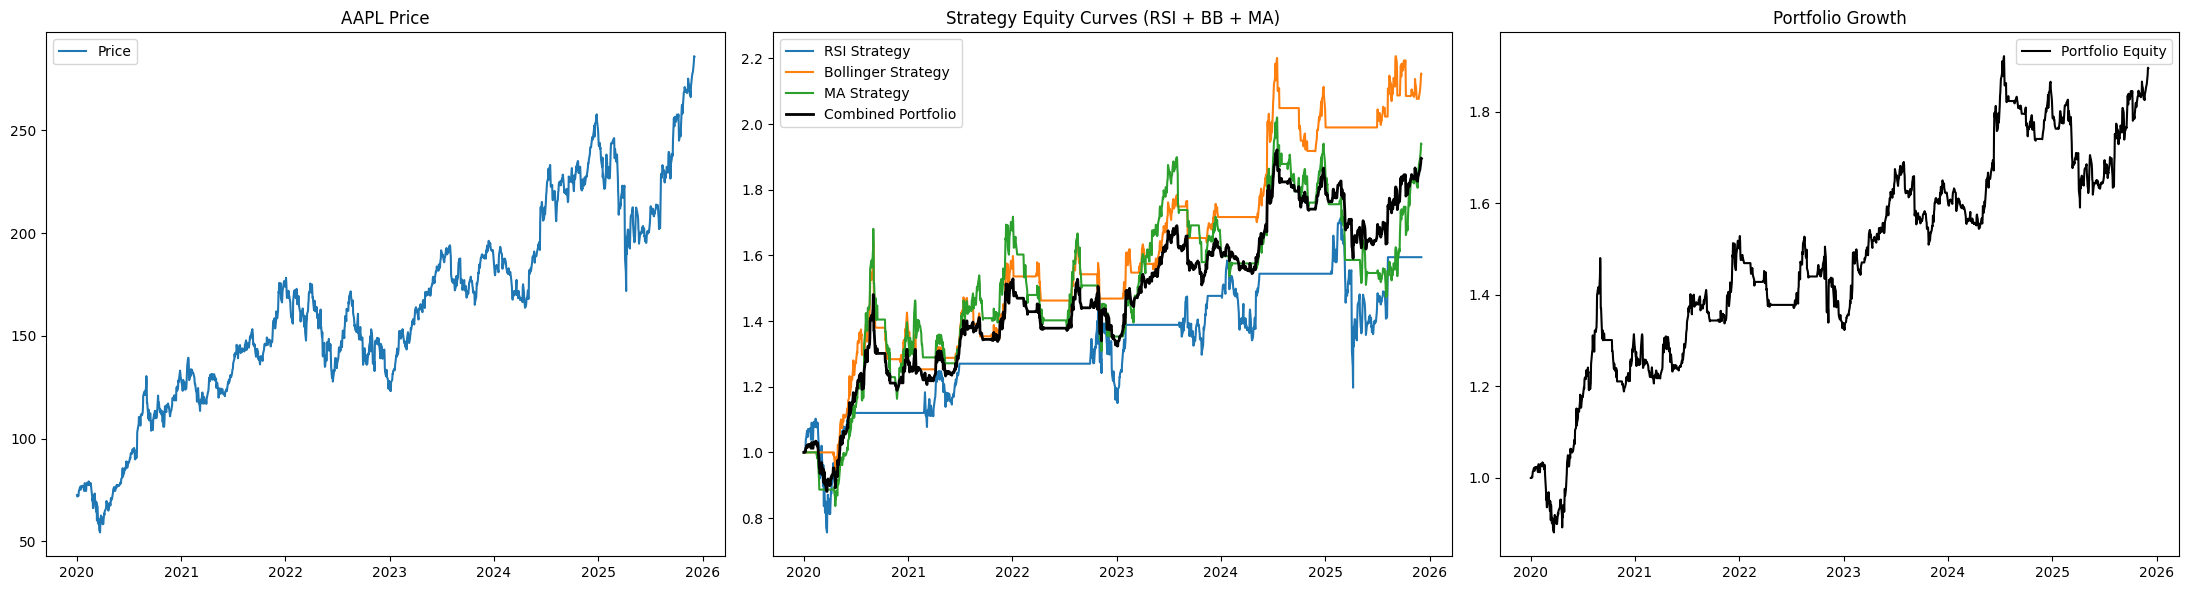

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf

# --PARAMETERS--
ticker = "AAPL"
start_date = "2020-01-01" #YYYY-MM-DD

# rsi
rsi_len = 14
rsi_buy = 30
rsi_sell = 70

# bb
bb_length = 20
bb_mult = 2

# ma
ma_fast = 10
ma_slow = 30

# portfolio split
w_rsi = 1/3
w_bb  = 1/3
w_ma  = 1/3


# --DATA DOWNLOAD--
df = yf.download(ticker, start=start_date, progress=False)
df["PRICE"] = df["Close"]
df.dropna(inplace=True)


# --INDICATORS--
# rsi
delta = df["PRICE"].diff()
gain = delta.clip(lower=0)
loss = -delta.clip(upper=0)
avg_gain = gain.ewm(alpha=1/rsi_len, adjust=False).mean()
avg_loss = loss.ewm(alpha=1/rsi_len, adjust=False).mean()
rs = avg_gain / avg_loss
df["RSI"] = 100 - (100 / (1 + rs))

# bb
df["mid"] = df["PRICE"].rolling(bb_length).mean()
df["std"] = df["PRICE"].rolling(bb_length).std()
df["upper"] = df["mid"] + bb_mult * df["std"]
df["lower"] = df["mid"] - bb_mult * df["std"]

# ma
df["MA_fast"] = df["PRICE"].rolling(ma_fast).mean()
df["MA_slow"] = df["PRICE"].rolling(ma_slow).mean()


# reversion
df["signal_rsi"] = np.where(df["RSI"] < rsi_buy, 1,
                     np.where(df["RSI"] > rsi_sell, 0, np.nan))
df["signal_rsi"] = df["signal_rsi"].ffill().fillna(0)
df["pos_rsi"] = df["signal_rsi"].shift(1).fillna(0)

df["ret_rsi"] = df["pos_rsi"] * df["PRICE"].pct_change().fillna(0)
df["equity_rsi"] = (1 + df["ret_rsi"]).cumprod()


# bollinger
df["signal_bb"] = np.where(df["PRICE"] > df["upper"], 1,
                     np.where(df["PRICE"] < df["mid"], 0, np.nan))
df["signal_bb"] = df["signal_bb"].ffill().fillna(0)
df["pos_bb"] = df["signal_bb"].shift(1).fillna(0)

df["ret_bb"] = df["pos_bb"] * df["PRICE"].pct_change().fillna(0)
df["equity_bb"] = (1 + df["ret_bb"]).cumprod()


# ma
df["signal_ma"] = np.where(df["MA_fast"] > df["MA_slow"], 1, 0)
df["pos_ma"] = df["signal_ma"].shift(1).fillna(0)

df["ret_ma"] = df["pos_ma"] * df["PRICE"].pct_change().fillna(0)
df["equity_ma"] = (1 + df["ret_ma"]).cumprod()


# --PORTFOLIO CALCULATION--
df["portfolio_equity"] = (
    w_rsi * df["equity_rsi"] +
    w_bb  * df["equity_bb"] +
    w_ma  * df["equity_ma"]
)


# --REPORT--
def sharpe(ret, periods=252):
    if ret.std() == 0: return 0
    return (ret.mean() * periods) / (ret.std() * np.sqrt(periods))

def max_drawdown(eq):
    roll_max = eq.cummax()
    dd = (eq - roll_max) / roll_max
    return dd.min()

total_returns = df["portfolio_equity"].pct_change().fillna(0)
combined_sharpe = sharpe(total_returns)
combined_mdd = max_drawdown(df["portfolio_equity"])
combined_cagr = df["portfolio_equity"].iloc[-1] ** (252/len(df)) - 1

print("-----------------------------------------------------")
print(f" STRATEGY REPORT (Portfolio) - {ticker}")
print("-----------------------------------------------------")
print(f"RSI Weight:            {w_rsi:.2f}")
print(f"Bollinger Weight:      {w_bb:.2f}")
print(f"MA Crossover Weight:   {w_ma:.2f}")
print("-----------------------------------------------------")
print(f"Sharpe Ratio:          {combined_sharpe:.3f}")
print(f"Max Drawdown:          {combined_mdd:.2%}")
print(f"CAGR:                  {combined_cagr:.2%}")
print(f"Final Equity:          {df['portfolio_equity'].iloc[-1]:.2f}x")
print("-----------------------------------------------------")


# --PLOTTING--
fig, axes = plt.subplots(1, 3, figsize=(22, 6))

# PRICE
axes[0].plot(df["PRICE"], label="Price")
axes[0].set_title(f"{ticker} Price")
axes[0].legend()

# strategy curves
axes[1].plot(df["equity_rsi"], label="RSI Strategy")
axes[1].plot(df["equity_bb"], label="Bollinger Strategy")
axes[1].plot(df["equity_ma"], label="MA Strategy")
axes[1].plot(df["portfolio_equity"], label="Combined Portfolio", linewidth=2, color="black")
axes[1].set_title("Strategy Equity Curves (RSI + BB + MA)")
axes[1].legend()

# portfolio growth
axes[2].plot(df["portfolio_equity"], label="Portfolio Equity", color="black")
axes[2].set_title("Portfolio Growth")
axes[2].legend()

plt.tight_layout()
plt.show()